In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import copy

### generate dataset

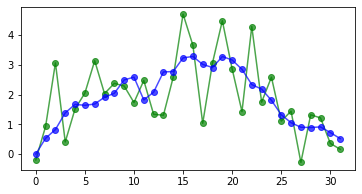

In [2]:
T = 32
ts = np.arange(T)
ms = np.zeros(T)
ys = np.zeros(T)

sm = 0.3
sy = 1.0

ms[0] = 0
ys[0] = np.random.normal(scale=sy)

np.random.seed(0)
for i in range(1, T):
    ms[i] = ms[i - 1] + np.random.normal(scale=sm) 
    ys[i] = ms[i] + np.random.normal(scale=sy) 

ms_init = ms.copy()
ys_init = ys.copy()

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(ts, ys, marker="o", color="g", alpha=0.7)
ax.plot(ts, ms, marker="o", color="b", alpha=0.7)

### minimize negative loglikehood via gradient descent

In [3]:
def get_loglik(ys, ms, vy, vm, T):
    ms = np.insert(ms, 0, ms[0])
    return 0.5 * np.log(2 * np.pi * vy) +\
           0.5 * np.log(2 * np.pi * vm) * (T - 1) / T +\
           0.5 * ((ys - ms[1:]) ** 2).sum() / vy / T +\
           0.5 * ((ms[1:] - ms[:-1]) ** 2).sum() / vm / T 

def get_gradient_vy(ys, ms, vy, vm, T):
    return +0.5 / vy +\
           -0.5 * ((ys - ms) ** 2).sum() / (vy ** 2) / T 

def get_gradient_vm(ys, ms, vy, vm, T):
    ms = np.insert(ms, 0, ms[0])
    return +0.5 * vm +\
           -0.5 * ((ms[1:] - ms[:-1]) ** 2).sum() / (vm ** 2) / T 

def get_gradient_logvy(ys, ms, vy, vm, T):
    return +0.5 +\
           -0.5 * ((ys - ms) ** 2).sum() / vy / T 

def get_gradient_logvm(ys, ms, vy, vm, T):
    ms = np.insert(ms, 0, ms[0])
    return +0.5 +\
           -0.5 * ((ms[1:] - ms[:-1]) ** 2).sum() / vm / T 

def get_gradient_ms(ys, ms, vy, vm, T):
    ms = np.insert(ms, -1, ms[-1])
    ms = np.insert(ms, 0, ms[0])
    return (ms[1:-1] - ys) / vy / T  +\
           (2 * ms[1:-1] - ms[:-2] - ms[2:]) / vm / T 

def initialize_params(T):
    ms = np.random.normal(size=T)
    vy = 1.5#np.random.rand()
    vm = 1.5#np.random.rand()
    return ms, vy, vm

done


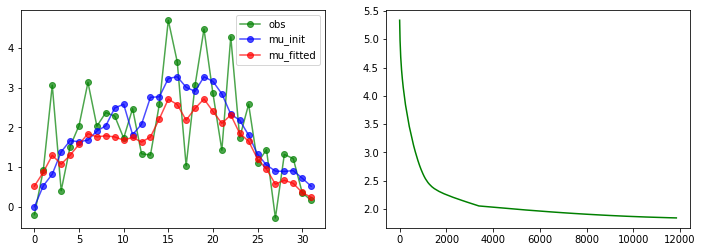

In [4]:
np.random.seed(123)

ms, vy, vm = initialize_params(T) # initial values
msi = copy.deepcopy(ms) 
vyi = copy.deepcopy(vy)
vmi = copy.deepcopy(vm)
logliks = [get_loglik(ys, ms, vy, vm, T)]

num_iters = 50000 # number of iterations
lr = 0.02 # learning rate
r = 1 # attenuate the learning rate
for i in range(num_iters):
    ms0 = copy.deepcopy(ms)
    vy0 = copy.deepcopy(vy)
    vm0 = copy.deepcopy(vm)

    # get gradients
    dms = get_gradient_ms(ys, ms0, vy0, vm0, T)
    dvy = get_gradient_vy(ys, ms0, vy0, vm0, T)
    dvm = get_gradient_vm(ys, ms0, vy0, vm0, T)

    # update params
    # add noise to make it like SGD
    ms -= lr * dms * r * (1 + np.random.normal(scale=0.1))
    vy -= lr * dvy * r * (1 + np.random.normal(scale=0.1))
    vm -= lr * dvm * r * (1 + np.random.normal(scale=0.1))

    logliks.append(get_loglik(ys, ms, vy, vm, T))
    
    # stop if loglik does not improve
    if np.abs(logliks[i] - logliks[i-1]) < 1e-9:
        print('done')
        break
    # attenuate the learning rate
    elif np.abs(logliks[i] - logliks[i-1]) < 1e-4:
        r = 1 / np.log10(i)

fig, axs = plt.subplots(1,2,figsize=(12, 4))
axs[0].plot(ts, ys_init, marker="o", color="g", alpha=0.7)
axs[0].plot(ts, ms_init, marker="o", color="b", alpha=0.7)
axs[0].plot(ts, ms, marker="o", color="r", alpha=0.7)
axs[0].legend(["obs", "mu_init", "mu_fitted"])
axs[1].plot(np.arange(len(logliks)), np.array(logliks), color="g")